# <div style="color:#1ed760; background-color:#191414; padding:10px;">Dynamic Playlist Generation Using Genetic Algorithm and Simulated Annealing</div>

<div style="color:#ffffff; background-color:#1db954; padding:10px;">

## Table of Contents
1. [Introduction](#introduction)
2. [Data Collection](#data-collection)
3. [Defining the Objective](#determining-the-objective)
4. [Genetic Algorithm](#genetic-algorithm)
   1. [Initialization](#genetic-algorithm-init)
   2. [Selection](#genetic-algorithm-selection)
   3. [Crossover](#genetic-algorithm-crossover)
   4. [Mutation](#genetic-algorithm-mutation)
   5. [Application](#genetic-algorithm-application)
   6. [An Example Run](#genetic-algorithm-example)
5. [Simulated Annealing Algorithm](#sa)
   1. [Application](#sa-app)
6. [Results and Comparison](#results-and-comparison)
7. [Example App](#example-app)
8. [References](#references)

</div>


<div id="introduction" style="background-color:#ffffff; padding:20px;">
<h2 style="color:#1ed760;">1. Introduction</h2>
<p style="background-color:#ffffff;">

Creating the perfect playlist is never an easy task, and even harder once you want it to match with your current mood. Some songs have features such as tempo, energy or rythm that make it more suitable for dancing or to lay in your bed thinking about all the things you need to do. Platforms such as Spotify provide access to millions of songs at our fingertips, making the process of playlist creation even more challenging. In this project, we try to use the power of otimization algorithms to generate playlist that are according to the vital need of the users.

The process of creating a playlist is subjective and personal and therefore there is not a perfect playlist to be created, but obtaining a collection of several good playlists. With that in mind we decided to implement stochastic algorithms and therefore introduce an element of randomness and exploration, allowing for the discovery of unique combinations of songs and enhancing the overall playlist creation process. The chosen algorithms were: Genetic Algorithm (GA), a population-based method that tries to refine a population of playlists over several generations by adding some changes (mutations) and selecting the most optimal playlists (selection) ; and Simulated Annealing (SA), which is a probabilistic method that plays with the balance of exploration and exploitation, letting the algorithm to escape from local optima in the search of the global optimum.

The songs dataset employed in this project was procured from Spotify's API, and it comprises a multitude of musical attributes for each track. We focus on three attributes that we thought could be the most representative of somebody’s mood: valence, energy, and popularity.

1. <i>Valence:</i> With values in the range 0 to 100, it captures the musical positiveness conveyed by a track. Songs with high valence sound more positive, while low valence tracks sound more negative.

2. <i>Energy:</i> With values from 0 to 100, it represents a perceptual measure of intensity and activity. Energetic tracks often feel fast, loud, and noisy.

3. <i>Popularity:</i> A measure from 0 to 100 representing the overall popularity of a track, based on the total number of plays and the recency of those plays.

These attributes, along with the track length, are vital for assessing the appropriateness of a track for inclusion in the playlist.

Our project aims to find an optimal set of songs that minimizes the total difference in these attributes from user-defined target values, while ensuring the total duration of the playlist falls within acceptable bounds. Consequently, the problem transforms into a multi-objective optimization problem, solved using our chosen algorithms. Our goal is to find the best balance between the theoretical benefits of these algorithms and the practical considerations of music playlist generation.

</p>
</div>



<div id="data-collection" style="background-color:#ffffff; padding:20px;">
<h2 style="color:#1ed760;">2. Data Collection</h2>
<p style="background-color:#ffffff;">

Our first step was exploring our data collection options from music streaming platforms. Among the popular ones Spotify was the only one with a useful and free API (Web API | Spotify for Developers, n.d.). The API was a hard one to use in Python without the help of a package called Spotipy (Spotipy, 2014/2023). Spotipy allowed us to navigate the authorization process of Spotify API with ease. Even though we decided to make our app work dynamicllay and pull data from Spotify on the go, this process was impossible without our application being published. This publication process requires permits from Spotify itself. Therefore we have dicided to work with pre-downloaded songs. We have written a script that downloads information on 100 songs for every genre available in Spotify.

</p>
</div>

In [3]:
# # Library import
# import spotipy
# from spotipy.oauth2 import SpotifyOAuth
# import json
# import time
# from statistics import mean


# # Authorization steps for the spotify API with the score provided as user-library-read
# scope = "user-library-read"
# sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope))


# # This function fetches n songs of a certain genre using tfrom spotify database
# def find_songs_genre(genre, n):
#     results = sp.recommendations(seed_genres=[genre], limit=n) # sp.recommendations fetcehs based on genre
#     songs = {} 
#     # Going through fetcehd songs we create a dictionary with several variables for each song
#     for track in results['tracks']:
#         attr = {}
#         auido_feat = sp.audio_features(track["id"])
#         attr["name"] = track["name"]
#         attr["artists"] = track["artists"][0]["name"]
#         attr["length"] = round(track["duration_ms"]/1000)
#         attr["pop"] = track["popularity"]
#         attr["valence"] = round(auido_feat[0]["valence"]*100, 2)
#         attr["energy"] = round(auido_feat[0]["energy"]*100, 2)
#         songs[track["name"]] = attr
#     return songs


# # This function collects x songs of a certain genre
# def make_a_list(genre, n, x):
#     songs = {}
#     while len(songs) < x:
#         songs_add = find_songs_genre(genre, n)
#         songs.update(songs_add)
#     return songs


# # This function creates a JSON for each genre
# def create_json(genre, n, x):
#     with open(f'song_db/{genre}.json', 'w') as f:
#         json.dump(make_a_list(genre, n, x), f, indent=4, sort_keys=True)

In [ ]:
# # This function applies the creates a JSON for each genre
# def for_every_genre(file, n, x):
#     with open(file, "r") as f:
#         genres = [line.strip() for line in f.readlines()]
#         genres = [line.strip("\'") for line in genres]
#     for genre in genres:
#         create_json(genre, n, x)

# file_name = "genres_remain.txt"
# for_every_genre(file_name, 100, 100)

<div id="data-collection2" style="background-color:#ffffff; padding:20px;">
<p style="background-color:#ffffff;">

Once the data collection scrpits are run we end up with a folder full of JSONs for each genre.

</p>
</div>

<div id="determining-the-objective" style="background-color:#ffffff; padding:20px;">
<h2 style="color:#1ed760;">3. Defining the Objective</h2>
<p style="background-color:#ffffff;">

Once we have learned the extent of our data set we have decided on which values to opimize for. We have picked length, energy, valence and popularity. The goal of our project was answering the query given by the user in the form of "I want to listen a x minute playlist with high/low energy and high/low danceability."

</p>
</div>

In [2]:
def calculate_fitness(solution, desired_values, songs, weights = {"energy_weight": 1.0, "valence_weight": 1.0, "popularity_weight": 1.0, "length_weight": 1.0}, penalty=True):
    
    total_diff = 0 # Initialize a variable to store the total difference

    # Set weights depending on user's needs
    energy_weight = weights["energy_weight"]
    valence_weight = weights["valence_weight"]
    popularity_weight = weights["popularity_weight"]
    length_weight = weights["length_weight"]
    exceed_length_penalty = 20  # penalty if playlist length exceeds the desired length

    # Normalization of song lengths
    min_length = min([songs[song]['length'] for song in songs])
    max_length = max([songs[song]['length'] for song in songs])
    song_lengths = [songs[song]['length'] for song in solution]
    normalized_lengths = [(x - min_length) / (max_length - min_length) for x in song_lengths]
    normalized_desirelen = (desired_values["length"] - min_length) / (max_length - min_length)
    
    for song_id in solution:
        song = songs[song_id]
        
        # Normalized differences for energy-valnce-popularity
        energy_diff = abs((song['energy']/100) - (desired_values['energy']/100))
        valence_diff = abs((song['valence']/100) - (desired_values['valence']/100))
        popularity_diff = abs((song['pop']/100) - (desired_values['pop']/100))

        # Weighted sum of differences
        total_diff += (energy_weight * energy_diff) + (valence_weight * valence_diff) + (popularity_weight * popularity_diff)
             
    length_diff = abs(sum(normalized_lengths) - normalized_desirelen)
    # Apply penalty if total playlist length exceeds the desired length
    if penalty:
        if (180-min_length)/(max_length-min_length) > length_diff:
            length_diff += exceed_length_penalty

    total_diff += length_weight * length_diff

    # Returns a float that represents the playlist's distance from the desired values. Lower score = better
    return total_diff

In [3]:
# Data collection
import os
import random
import json
import matplotlib.pyplot as plt
from statistics import mean
import math
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Setting directory
cwd = os.getcwd()
cwd += "/song_db"

# Turns genre JSON into a directory
def get_genre_dict(path):
    
    json_files = os.listdir(path)
    genre_dict = {}
    
    for file in json_files:
        file_path = f"{path}/{file}"
        genre = file.split(".")[0]
        with open(file_path) as fp:
            genre_dict[genre] = json.load(fp)
        
    return genre_dict

In [4]:
# Get the genres dictionary and the list of genres
genre_dict = get_genre_dict(cwd)
genres = list(genre_dict.keys())
# Select number of genres you want 
num_of_gens = 3
selected_genres = random.sample(genres, num_of_gens)
# Get all songs form those genres
songs = {}

for genre in selected_genres:
    songs.update(genre_dict[genre])

print(f"The selected genres are {selected_genres}")

The selected genres are ['alt-rock', 'black-metal', 'blues']


<div id="genetic-algorithm" style="background-color:#ffffff; padding:20px;">
<h2 style="color:#1ed760;">4. Genetic Algorithm</h2>
<p style="background-color:#ffffff;">

Genetic Algorithms (GAs) are a powerful optimization technique inspired by the principles of natural selection and genetics. In the context of playlist generation, GAs provide the means to search for the most suitable combination of songs that align with specific criteria or objectives. By treating playlists as individuals within a population, GAs can apply evolutionary operators such as selection, crossover, and mutation to iteratively refine the playlists. In the evolutionary process, individuals are evaluated based on a fitness function, which determines how close they are to desired values provided by the user. 

The utilization of GAs enables the exploration of an enormous search space of songs that could be included in the playlist. This algorithm offers a dynamic and adaptive approach that can constantly generate diverse and personalized playlists that align with the different tastes and contexts.

A psuedocode of genetic algorithm adapted to our problem is as follows (Katoch et al., 2021):

</p>
</div>

Initialize a population of playlists.

While termination condition not met:
    
    Evaluate each playlist in the population.
    (We can do it by using the calculate_fitness on every song in our playlists.)

    Perform selection on population.
    (Fitter playlists of the population survive.)

    Perform crossover to generate offspring.

    Perform mutation on the offspring.
    (Mutation is used to maintain the diversity for further playlists)

    Replace the population with the new generation of individuals.
    
End While

Return the best solution from the current population.


<div id="genetic-algorithm-init" style="background-color:#ffffff; padding:20px;">
<h4 style="color:#1ed760;">Initialization</h4>
<p style="background-color:#ffffff;">

GA starts by generating a random initial population of playlists. These playlists serve as the initial set of potential solutions for the optimization problem. Each playlist within the population represents a candidate solution that will undergo evolutionary operations such as selection, crossover, mutation, insertion and deletion.


</p>
</div>

In [12]:
# Constants
TOTAL_NUM_SONGS = len(songs)
POPULATION_SIZE = 25
NUM_GENERATIONS = 2000


def generate_individual(songs, desired_length):
    # Average song length according to spoti API, so that we can start with an initial guess that has a close number of songs to optimum
    song_indices = random.sample(range(TOTAL_NUM_SONGS), int(desired_length/197))
    return [list(songs.keys())[i] for i in song_indices]

<div id="genetic-algorithm-selection" style="background-color:#ffffff; padding:20px;">
<h4 style="color:#1ed760;">Selection</h4>
<p style="background-color:#ffffff;">

Selection is a process that determines which individuals from the playlist population are chosen for reproduction,  based on their fitness. By favoring individuals with better fitness, selection promotes the propagation of desirable traits throughout successive generations, i.e. playlists with songs with attributes more similar to the desired ones will have more chances of being selected.

</p>
</div>

In [13]:
# SELECTION
def selection(population, desired_values):
    fitness_scores = [calculate_fitness(individual, desired_values, songs) for individual in population]
    sorted_population = [x for _, x in sorted(zip(fitness_scores, population))]
    selected_population = sorted_population[:int(POPULATION_SIZE * 0.2)]  # Select top 20% fittest individuals
    return selected_population

# we end up with a population of 10 (20% POPULATION_SIZE)

<div id="genetic-algorithm-crossover" style="background-color:#ffffff; padding:20px;">
<h4 style="color:#1ed760;">Crossover</h4>
<p style="background-color:#ffffff;">

The crossover process involves combining genetic information from two parent individuals to create offspring. In this particular context, crossover can be applied by taking portions from two parent playlists and exchanging them to generate new playlists. This allows for the exploration of different song combinations and can introduce diversity into the population. In this step it is important to be aware of the introduction of duplicates, as the song parameters of a certain track might be too optimum, the algorithm could try to repeat this song many times.

</p>
</div>

In [14]:
def crossover(parent1, parent2):
    # select random crossover point
    # this point will depend on the shortest sequence to not get IndexError
    max_length = min(len(parent1), len(parent2))
    
    ## crossover_point = random.randint(1, NUM_SONGS - 1)
    if max_length > 2:
        crossover_point = random.randint(1, max_length - 1)
    else:
        return parent1, parent2
    
    # get two childs with the crossover of the parents
    
    ## child1, child2 = list(range(NUM_SONGS)), list(range(NUM_SONGS))
    child1, child2 = list(range(len(parent1))), list(range(len(parent2)))
    
    # we avoid duplicates with this for loop
    # we do crossover until crossover point
    for i in range(0, crossover_point):
        
        if parent1[i] not in parent2:
            child2[i] = parent1[i]
        else:
            child2[i] = parent2[i]

        if parent2[i] not in parent1:
            child1[i] = parent2[i]
        else:
            child1[i] = parent1[i]
            
    # from crossover point onward is the same
    for i in range(crossover_point, len(child1)):
        child1[i] = parent1[i]
    for i in range(crossover_point, len(child2)):
        child2[i] = parent2[i]
    
    return child1, child2

def perform_crossover(selected_population):
    offspring_population = []
    # get a new population POPULATION_SIZE
    while len(offspring_population) < POPULATION_SIZE:
        parent1, parent2 = random.sample(selected_population, 2)
        child1, child2 = crossover(parent1, parent2)
        offspring_population.extend([child1, child2])
    return offspring_population[:POPULATION_SIZE]

# go back to a population of POPULATION_SIZE (50) with its individuals crossed

<div id="genetic-algorithm-mutation" style="background-color:#ffffff; padding:20px;">
<h4 style="color:#1ed760;">Mutation</h4>
<p style="background-color:#ffffff;">


Mutation introduces random changes into individual playlists within the population. It serves as a mechanism to introduce novel elements and prevent the algorithm from converging prematurely to suboptimal solutions. In the context of music playlist optimization, mutation involves swapping a song from a different one from the pool of songs.

Another types of mutation that we applied are insertion and deletion. They refer to the addition or removal of individuals to the population. In this context of playlist optimization, insertion is used to introduce new songs that have not been generated through crossover or mutation, helping to explore a wider range of possibilities and can lead to the discovery of unique combinations of songs. On the other hand, deletion is used to randomly erase songs with the intention to improve the fitness of the playlist.

The selection between random change, insertion, and deletion depend on the length of the playlist and its difference with the desired length.

</p>
</div>


In [15]:
def mutation(individual, songs, desired_values):       
    # Calculate the total length of the playlist, find availaible songs and set a length threshold (%20 in our case)
    playlist_length = sum(songs[song_id]['length'] for song_id in individual)
    available_songs = list(set(songs.keys()) - set(individual))  # songs not in the playlist yet
    length_threshold = 0.2 

    # Deletion if the playlist length is greater than 120% of the desired length and the playlist has more than one song
    if playlist_length > (1 + length_threshold) * desired_values['length'] and len(individual) > 1:
        individual.remove(random.choice(individual))
    # Insertion if the playlist length is less than 80% of the desired length and there are still songs available
    elif playlist_length < (1 - length_threshold) * desired_values['length'] and available_songs:
        # Insertion: Add a random song to the playlist
        individual.append(random.choice(available_songs))
    else:
        # Swap the playlist length is within the acceptable range, swap a random song in the playlist with a random song from the available songs
        if available_songs:
            swap_out = random.choice(individual)
            swap_in = random.choice(available_songs)
            individual[individual.index(swap_out)] = swap_in
    return individual


def perform_mutation(offspring_population, songs, desired_values):
    mutated_population = [mutation(individual, songs, desired_values) for individual in offspring_population]
    return mutated_population

<div id="genetic-algorithm-application" style="background-color:#ffffff; padding:20px;">
<h4 style="color:#1ed760;">Application</h4>
<p style="background-color:#ffffff;">

By applying above mentioned methods back to back we can create a "best" individual playlist. 

</p>
</div>


In [16]:
def genetic_algorithm(songs, desired_values):
    fitness = []
    population = [generate_individual(songs, desired_values["length"]) for i in range(POPULATION_SIZE)]
    for _ in range(NUM_GENERATIONS):
        selected_population = selection(population, desired_values)
        fitness.append(mean([calculate_fitness(indiv, desired_values, songs) for indiv in selected_population]))
        offspring_population = perform_crossover(selected_population)
        mutated_population = perform_mutation(offspring_population, songs, desired_values)
        population = mutated_population

    # Get the fittest individual from the final population
    fitness_scores = [calculate_fitness(individual, desired_values, songs) for individual in population]
    best_individual = population[fitness_scores.index(min(fitness_scores))]
    return best_individual, fitness

<div id="genetic-algorithm-example" style="background-color:#ffffff; padding:20px;">
<h4 style="color:#1ed760;">An Example Run</h4>
</div>

In [17]:
desired_values = {
    'length': 7200,
    'energy': 70,
    'valence': 60,
    'pop': 65
}

algo = genetic_algorithm(songs, desired_values)
best_individual = algo[0]
ga_fitness_scores = algo[1]
print("Best Individual:", best_individual)
print(f"Length difference: {round(abs(sum([songs[songid]['length'] for songid in best_individual]) - desired_values['length']), 2)}")
print(f"Pop difference: {round(abs(mean([songs[songid]['pop'] for songid in best_individual]) - desired_values['pop']), 2)}")
print(f"Energy difference: {round(abs(mean([songs[songid]['energy'] for songid in best_individual]) - desired_values['energy']), 2)}")
print(f"Valence difference: {round(abs(mean([songs[songid]['valence'] for songid in best_individual]) - desired_values['valence']), 2)}")
print(f"Fitness Score: {round(calculate_fitness(best_individual, desired_values, songs), 3)}")

Best Individual: ['Liar', 'I Am Trying to Break Your Heart', 'All I Want', 'Time To Bring The Pain', 'Flood II - 2006 Remaster', 'Impossible Germany', 'The Killing Moon', 'The Ghost Within', 'Reptile', 'Heart and Soul', 'Kill EVERYBODY', 'One More Time', 'Hunger Strike', 'The Adventures of Rain Dance Maggie', 'Be Yourself', 'Cold Hard Bitch', 'Sex & Candy', '100% In The Bitch - Downlink Remix', 'Strange', 'Live for the Night', 'Scary Monsters and Nice Sprites - Zedd Remix', 'Kiss Kiss Bang Bang - 12" version', 'Sink to the Bottom', 'Another Day - xKore Remix', 'The Distance', 'Missed the Boat', 'On Melancholy Hill', 'Love Like Blood', 'Ragga Bomb (with Ragga Twins)']
Length difference: 852
Pop difference: 14.48
Energy difference: 4.94
Valence difference: 6.34
Fitness Score: 12.9


<div id="sa" style="background-color:#ffffff; padding:20px;">
<h2 style="color:#1ed760;">5. Simulated Annealing</h2>
<p style="background-color:#ffffff;">

Simulated Annealing (SA) is an optimization algorithm inspired by the annealing process in metallurgy. SA starts with an initial random solution and iteratively explores the search space to find an optimal solution. Unlike genetic algorithms, SA does not rely on a population of solutions but rather focuses on a single solution at a time. 

This technique employs the fitness function to quantify how well the solution satisfies the desired values. During the iterative process, SA allows for both uphill and downhill moves and explores neighboring solutions by perturbing the current solution. The perturbation involves adding or deleting songs depending on whether the playlist’s length is much bigger or lower than the desired length, or by swapping songs if the playlist has a length within the range of 1 minute under or above the desired length.

SA also incorporates a temperature parameter that controls the acceptance of uphill moves. Initially, the temperature is high, allowing for more exploratory moves, including accepting solutions with worse objective function values. As the algorithm progresses, the temperature gradually decreases, reducing the acceptance of suboptimal solutions and guiding the search towards the optimal solution. The cooling parameter determines the rate at which the temperature decreases. By adjusting the cooling schedule, SA can strike a balance between exploration and exploitation, improving the chances of finding an optimal playlist.

The iterative process of SA continues until a stopping criterion is met, in our case, reaching a stopping temperature value. Throughout the iterations, SA aims to converge towards the best solution playlist found so far, optimizing the composition of the playlist according to the desired values.

SA has as pseudocode as follows (Rere et al., 2015):

![SA Pseudocode](/Users/borakaraaslan/github_repos/stmo_spoti/pseudocode_SA.png)

</p>
</div>

In [18]:
def generate_neighbor(current_playlist, songs, desired_values):
    new_playlist = current_playlist.copy()
    song_ids = list(songs.keys())

    # Insertion or deletion if playlist is too short or too long
    current_length = sum(songs[song_id]['length'] for song_id in new_playlist)
    # If the playlist is shorter than desired, insert a new song
    if current_length < desired_values['length']-180: # -60 for the flexibility.
        new_song = random.choice(song_ids)
        # Making sure we don't have duplicates
        while new_song in new_playlist:
            new_song = random.choice(song_ids)
        new_playlist.append(new_song)
    # If the playlist is longer than desired, delete a random song
    elif current_length > desired_values['length']+180: # +60 is there for flexibility
        new_playlist.remove(random.choice(new_playlist))
    # If the playlist length is appropriate, swap two songs
    else:
        if len(new_playlist) > 2:
            idx1, idx2 = random.sample(range(len(new_playlist)), 2)
            additions = random.sample(song_ids, 2)
            while additions[0] in new_playlist or additions[1] in new_playlist:
                additions = random.sample(song_ids, 2)
            new_playlist[idx1], new_playlist[idx2] = additions[0], additions[1]
    return new_playlist


def simulated_annealing(songs, initial_temperature, cooling_rate, desired_values):
    # Initialize the playlist with random songs
    current_playlist = random.sample(list(songs.keys()), int(desired_values["length"]/197))
    current_fitness = calculate_fitness(current_playlist, desired_values, songs, penalty=False)
    fitness = [current_fitness]
    # Set the startng temperature
    temperature = initial_temperature

    # Run the code until temperature reaches 1
    while temperature > 1:
        # Generate a new newighboring playlist
        new_playlist = generate_neighbor(current_playlist, songs, desired_values)
        new_fitness = calculate_fitness(new_playlist, desired_values, songs, penalty=False)

        # If the new playlist is better, accept it
        # If not, accept it with a certain probability
        if new_fitness < current_fitness or random.uniform(0.95, 1.05) < math.exp((current_fitness - new_fitness) / temperature):
            current_playlist = new_playlist
            current_fitness = new_fitness
        fitness.append(current_fitness)
        # Reduce temperature
        temperature *= cooling_rate
    return current_playlist, fitness


<div id="sa-app" style="background-color:#ffffff; padding:20px;">
<h4 style="color:#1ed760;">Application</h4>
<p style="background-color:#ffffff;">

By applying above mentioned methods back to back we can create a "best" playlist. 

</p>
</div>


In [19]:
algo = simulated_annealing(songs, initial_temperature=10000, cooling_rate=0.995, desired_values=desired_values)
best_playlist = algo[0]
sa_fitness_scores = algo[1]
print(f"Best playlist: {best_playlist}")
print(f"Fitness score: {round(sa_fitness_scores[-1], 3)}")

Best playlist: ['Kiss Kiss Bang Bang - 12" version', 'Liar', 'Personal Jesus', 'Sex & Candy', 'Love Like Blood', "Dance D'Amour", 'I Am Trying to Break Your Heart', 'Impossible Germany', 'The Adventures of Rain Dance Maggie', 'Pursuit Of Happiness - Extended Steve Aoki Remix (Explicit)', 'Stay With Me', 'Heart and Soul', 'Live for the Night', 'I Will Steal You Back', 'Kill EVERYBODY', 'Wolf Moon (Including Zoanthropic Paranoia)', 'Scary Monsters and Nice Sprites - Zedd Remix', 'Be Yourself', 'Cold Hard Bitch', 'The Killing Moon', 'On Melancholy Hill', 'Ragga Bomb (with Ragga Twins)', 'Missed the Boat', 'All I Want', 'Reptile']
Fitness score: 11.251


<div id="results" style="background-color:#ffffff; padding:20px;">
<h2 style="color:#1ed760;">6. Results and Comparison</h2>
<p style="background-color:#ffffff;">



</p>
</div>

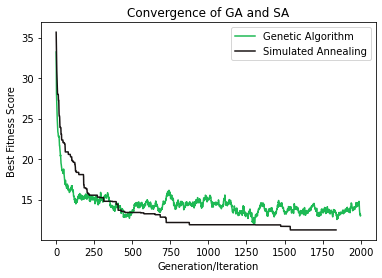

In [20]:
# assuming best_scores_ga and best_scores_sa are your data
best_scores_ga = ga_fitness_scores  # Best scores over generations for GA
best_scores_sa = sa_fitness_scores  # Best scores over iterations for SA

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data
ax.plot(best_scores_ga, label='Genetic Algorithm', color='#1DB954')
ax.plot(best_scores_sa, label='Simulated Annealing', color='#191414')

# Customize the plot
ax.set_title('Convergence of GA and SA')
ax.set_xlabel('Generation/Iteration')
ax.set_ylabel('Best Fitness Score')
ax.legend()

# Show the plot
plt.show()

<div id="sa-app" style="background-color:#ffffff; padding:20px;">
<p style="background-color:#ffffff;">

Here we can see how both algorithms converge on the long run. Even though both algorithms converge on a similar value we can see that SA converges more consistently and also with a lower score. GA's wide base of possible solutions allows for extensive exploration of the solution space. But GA has a tendency to converge early and get stuck in a local minimum. This can be due to multiple reasons. In our case this is probably due to the lack of diversity in populations due to number of songs.

SA, on the other hand, works on a single solution. Even though this might seem like it would diminish the exploration capacity of SA, acceptance of worse solutions in the initial steps actually increase the exploration capacity by a wide margin. As the exploration widens the solution space at the high temperature steps, the focus on better solutions at the low temperature steps allows the algorithm to hone on the best-found solution. 

Both algorithms are stochastic in nature. We think that this is important in a task such as playlist creation. But it is also the reason for not finding an exact optimum solution for the task. But in our case optimum solutions would create identical playlists. And a playlist recommendation tool which always recommends the same songs wouldn't be too popular.

</p>
</div>


In [21]:
# Violin plots for fitness scores

mult_length = list(range(300, 3000))
mult_pop = random.choices(list(range(20,90)), k=len(mult_length))
mult_val = random.choices(list(range(20,90)), k=len(mult_length))
mult_energy = random.choices(list(range(20,90)), k=len(mult_length))

final_fitness_scores_ga = []
final_fitness_scores_sa = []

# 
for k in range(150):
    desired_values = {"length":random.sample(mult_length, 1)[0],
                      "energy": random.sample(mult_energy, 1)[0],
                      "valence": random.sample(mult_val, 1)[0],
                      "pop": random.sample(mult_pop, 1)[0]}
    genre_dict = get_genre_dict(cwd)
    genres = list(genre_dict.keys())
    # Select number of genres you want 
    num_of_gens = 3
    selected_genres = random.sample(genres, num_of_gens)
    # Get all songs form those genres
    
    songs = {}
    for genre in selected_genres:
        songs.update(genre_dict[genre])
    TOTAL_NUM_SONGS = len(songs)
    ga = genetic_algorithm(songs, desired_values)
    final_fitness_scores_ga.append(ga[1][-1])
    sa = simulated_annealing(songs, initial_temperature=100000, cooling_rate=0.995, desired_values=desired_values)
    final_fitness_scores_sa.append(sa[1][-1])  

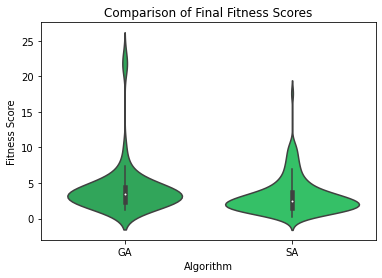

In [22]:
# assuming that final_fitness_scores_ga and final_fitness_scores_sa are your data
# Combine the scores into a dataframe
df = pd.DataFrame({
    'Score': final_fitness_scores_ga + final_fitness_scores_sa,
    'Algorithm': ['GA'] * len(final_fitness_scores_ga) + ['SA'] * len(final_fitness_scores_sa)
})

# Create a figure and axis
fig, ax = plt.subplots()

# Make the violin plot
sns.violinplot(x='Algorithm', y='Score', data=df, ax=ax, palette=['#1db954', '#1ed760'])

# Customize the plot
ax.set_title('Comparison of Final Fitness Scores')
ax.set_ylabel('Fitness Score')

# Show the plot
plt.show()


<div id="sa-app" style="background-color:#ffffff; padding:20px;">
<p style="background-color:#ffffff;">

After running each method for 150 iterations, we observe that both algorithms ouput comparable results, although SA outperforms GA by generating slightly better-fitted playlists. However, as previously commented, one advantageous aspect of GA lies in its capability to produce a population of random playlists. While these playlists may not have the highest fitness score, they maintain an acceptable level of quality. This ability to generate multiple diverse individuals may be preferred by users over obtaining a single better-fitted playlist. Ultimately, the choice between SA and GA depends on the specific needs and preferences of the users, considering factors such as the desired level of optimization and the importance of playlist diversity.

</p>
</div>


<div id="app" style="background-color:#ffffff; padding:20px;">
<h2 style="color:#1ed760;">7. Example App</h2>
<p style="background-color:#ffffff;">



</p>
</div>

In [5]:
import ipywidgets as widgets

# Define the energy slider
energy_slider = widgets.IntSlider(
    value=50,
    min=0,
    max=100,
    description='Energy:',
)

# Define the valence slider
valence_slider = widgets.IntSlider(
    value=50,
    min=0,
    max=100,
    description='Valence:',
)

# Define the popularity slider
popularity_slider = widgets.IntSlider(
    value=50,
    min=0,
    max=100,
    description='Popularity:',
)

# Define the length text input
length_text = widgets.IntText(
    value=0,
    description='Length:',
)

# Define the genre dropdown
genres = list(genre_dict.keys())  # Replace with your list of genres
genre_dropdown = widgets.SelectMultiple(
    options=genres,
    description='Genres:',
)

# Display the widgets
display(energy_slider, valence_slider, popularity_slider, length_text, genre_dropdown)

IntSlider(value=50, description='Energy:')

IntSlider(value=50, description='Valence:')

IntSlider(value=50, description='Popularity:')

IntText(value=0, description='Length:')

SelectMultiple(description='Genres:', options=('french', 'drum-and-bass', 'alternative', 'brazil', 'club', 'fo…

In [27]:
desired_values = {
    'length': length_text.value,
    'energy': energy_slider.value,
    'valence': valence_slider.value,
    'pop': popularity_slider.value
}

songs = {}
for genre in genre_dropdown.value:
    songs.update(genre_dict[genre])
TOTAL_NUM_SONGS = len(songs)

ga = genetic_algorithm(songs, desired_values)
sa = simulated_annealing(songs, initial_temperature=100000, cooling_rate=0.999, desired_values=desired_values)

print(sorted(ga[0]))
print(sorted(sa[0]))



['Belle', 'Boa Sorte / Good Luck (feat. Ben Harper)', 'Cara valente', 'Carolina', 'Double je - Remix', 'Faroeste Caboclo', 'Geni E O Zepelim', 'La Belle Et Le Bad Boy', 'La Liste', 'La ritournelle', 'La vie est ailleurs', 'Le Petit homme', 'Le téléphone pleure', 'Melhor do Que Ontem', 'Ne Me Quitte Pas', 'Ouro De Tolo', 'Preta Pretinha', "Problèmes d'adultes", 'Quem de nós Dois (La Mia Storia Tra Le Dita)', 'Samba Da Bencao', 'Se...', 'Shimbalaiê', 'Siffler sur la colline', 'Sutilmente', 'Telegrama', 'Tu trouveras', 'À cause des garçons', 'Último Romance - Ao Vivo']
['Around the World', 'Belle', 'Boa Sorte / Good Luck (feat. Ben Harper)', 'Cara valente', 'Carolina', 'Faroeste Caboclo', 'La Belle Et Le Bad Boy', 'La Liste', 'La montagne', 'La ritournelle', 'Le baiser', 'Le téléphone pleure', 'Mistério do Planeta', 'Ne Me Quitte Pas', 'Preta Pretinha', "Problèmes d'adultes", 'Quem de nós Dois (La Mia Storia Tra Le Dita)', 'Samba Da Bencao', 'Se...', 'Shimbalaiê', 'Sina', 'Sutilmente', 'T

<div id="references" style="background-color:#ffffff; padding:20px;">
<h2 style="color:#1ed760;">8. References</h2>
<p style="background-color:#ffffff;">

Katoch, S., Chauhan, S. S., & Kumar, V. (2021). A review on genetic algorithm: Past, present, and future. Multimedia Tools and Applications, 80(5), 8091–8126. https://doi.org/10.1007/s11042-020-10139-6

Rere, L. M. R., Fanany, M. I., & Arymurthy, A. M. (2015). Simulated Annealing Algorithm for Deep Learning. Procedia Computer Science, 72, 137–144. https://doi.org/10.1016/j.procs.2015.12.114

Spotipy. (2023). [Python]. Spotipy. https://github.com/spotipy-dev/spotipy (Original work published 2014)

Web API | Spotify for Developers. (n.d.). Retrieved June 24, 2023, from https://developer.spotify.com/documentation/web-api


</p>
</div>

